# Fixing the Vanishing Gradient Problem with Rectified Linear Unit (ReLU)

## Example Problem: Two Circles Binary Classification

To help investigate the problem, we study the classic binary classification problem. We use the [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) function provided by `scikit-learn` to create a binary classification problem with given number of samples and statistical noise.

In [1]:
# import required libraries
from sklearn.datasets import make_circles
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from skorch import NeuralNetBinaryClassifier

We create the dataset with $X$ denoting the input variables (coordinates in the Cartesian plane) and the label vector $y$ denoting class values in $\{0, 1\}$. The points are arranged in two concentric circles for the two classes, with parameters:
- `n_samples`: number of points in the dataset, where half of the data points will be drawn for each circle
- `noise`: the standard deviation of the noise, `noise = 0.0` indicates no noise or points drawn exactly from the circles
- `random_state`: seed for the pseudorandom number generator for reproducibility

The statistical noise causes the overlap of the points in the two classes.

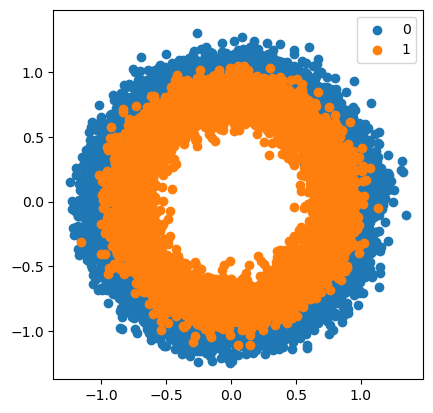

In [2]:
# generate circles
X, y = make_circles(n_samples=10000, noise=0.1, random_state=1)

for i in range(len(np.unique(y))):
    sample_indices = np.where(y == i)
    plt.scatter(X[sample_indices, 0], X[sample_indices, 1], label=str(i))
plt.legend()
plt.axis('square');

## Multi-Layer Perceptron

In [3]:
# select device based on hardware
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
# scale the data into [-1., 1.]
scaler = MinMaxScaler(feature_range=(-1., 1.))
X = scaler.fit_transform(X)

In [5]:
X, y = X.astype(np.float32), y.astype(np.float32)

In [6]:
# train/test split
num_train = int(0.8 * len(y))
trainX, testX = X[:num_train, :], X[num_train:, :]
trainy, testy = y[:num_train], y[num_train:]

In [7]:
# weight initializer function
def init_weights(module):
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.uniform_(module.weight, 0., 1.)

In [8]:
# some common hyperparameters
max_epochs = 500
lr = 0.1
verbose = 0

In [9]:
class MultiLayerPerceptronTanh(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp =  torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=5),
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=5, out_features=1),
        )

    def forward(self, x):
        init_weights(self.mlp)
        return self.mlp(x)

In [10]:
net_tanh = NeuralNetBinaryClassifier(
    MultiLayerPerceptronTanh,
    max_epochs=max_epochs,
    lr=lr,
    device=device,
    verbose=verbose
)

In [11]:
history_tanh = net_tanh.fit(trainX, trainy)

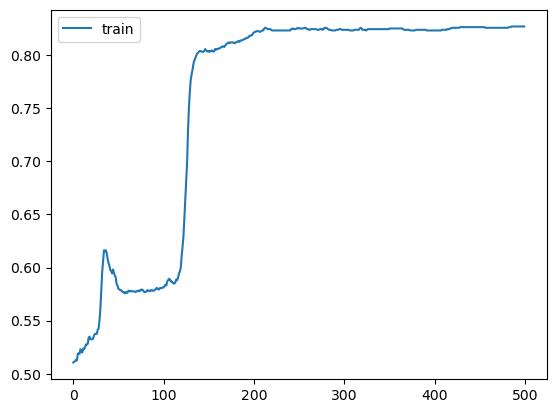

In [12]:
plt.plot(history_tanh.history[:, 'valid_acc'], label='train')
plt.legend()
plt.show()

In [13]:
# evaluate the model
predictions_tanh = net_tanh.predict(testX)
test_acc_tanh = np.sum(predictions_tanh == testy.astype(int)) / len(testy)
print(f'Average test accuracy: {test_acc_tanh}')

Average test accuracy: 0.8285


In [14]:
del history_tanh

In [15]:
class MultiLayerPerceptronReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp =  torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=5),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=5, out_features=1)
        )
    def forward(self, x):
        init_weights(self.mlp)
        return self.mlp(x)

In [16]:
net_relu = NeuralNetBinaryClassifier(
    MultiLayerPerceptronReLU,
    max_epochs=max_epochs,
    lr=lr,
    device=device,
    verbose=verbose
)

In [17]:
history_relu = net_relu.fit(trainX, trainy)

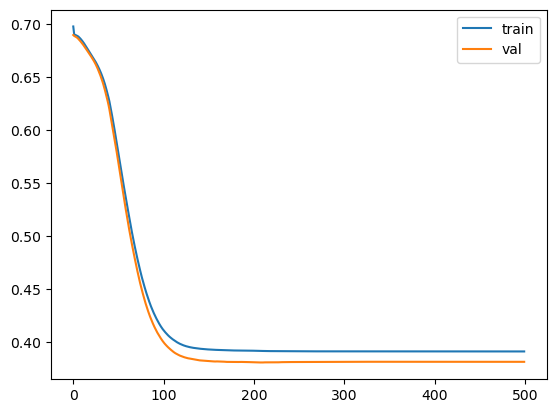

In [18]:
plt.plot(history_relu.history[:, 'train_loss'], label='train')
plt.plot(history_relu.history[:, 'valid_loss'], label='val')
plt.legend()
plt.show()

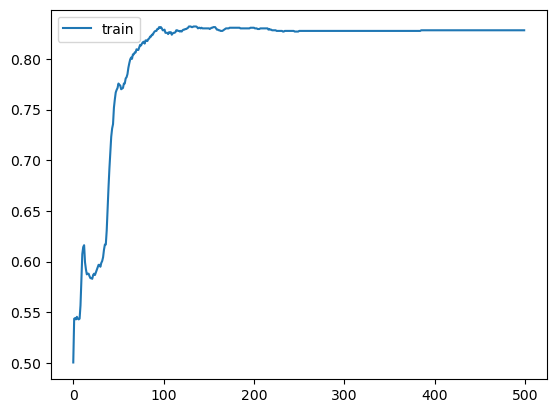

In [19]:
plt.plot(history_relu.history[:, 'valid_acc'], label='train')
plt.legend()
plt.show()

In [20]:
# evaluate the model
predictions_relu = net_relu.predict(testX)
test_acc_relu = np.sum(predictions_relu == testy.astype(int)) / len(testy)
print(f'Average test accuracy: {test_acc_relu}')

Average test accuracy: 0.815


## Deeper Models

In [21]:
layer = torch.nn.Linear(in_features=5, out_features=5)

In [22]:
# defaults to Kaiming He initialization
class DeepNeuralNetworkTanh(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.deep =  torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=5),
            torch.nn.Tanh(),
            layer,
            torch.nn.Tanh(),
            layer,
            torch.nn.Tanh(),
            layer,
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=5, out_features=1)
        )
    def forward(self, x):
        init_weights(self.deep)
        return self.deep(x)

In [23]:
deepnet_tanh = NeuralNetBinaryClassifier(
    DeepNeuralNetworkTanh,
    max_epochs=max_epochs,
    lr=lr,
    device=device,
    verbose=verbose
)

In [24]:
history_deeptanh = deepnet_tanh.fit(trainX, trainy)

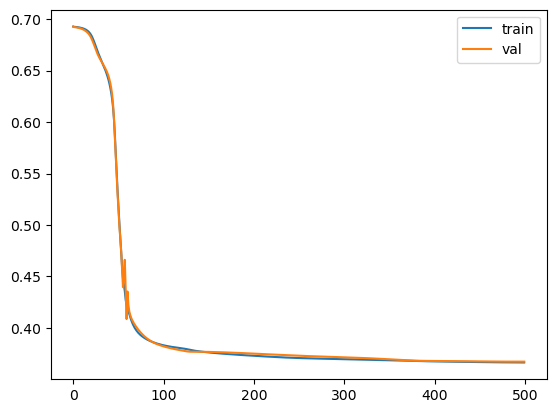

In [25]:
plt.plot(history_deeptanh.history[:, 'train_loss'], label='train')
plt.plot(history_deeptanh.history[:, 'valid_loss'], label='val')
plt.legend()
plt.show()

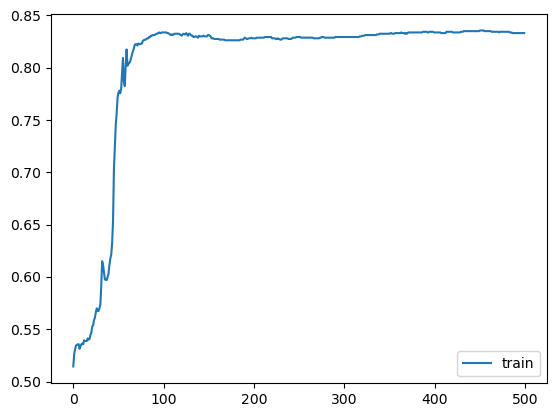

In [26]:
plt.plot(history_deeptanh.history[:, 'valid_acc'], label='train')
plt.legend()
plt.show()

In [27]:
# evaluate the model
predictions_deeptanh = deepnet_tanh.predict(testX)
test_acc_deeptanh = np.sum(predictions_deeptanh == testy.astype(int)) / len(testy)
print(f'Average test accuracy: {test_acc_deeptanh}')

Average test accuracy: 0.8325


In [28]:
del history_deeptanh

In [29]:
del deepnet_tanh

In [30]:
# defaults to Kaiming He initialization
class DeepNeuralNetworkReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.deep =  torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=5),
            torch.nn.ReLU(),
            layer,
            torch.nn.ReLU(),
            layer,
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=5, out_features=1)
        )
    def forward(self, x):
        init_weights(self.deep)
        return self.deep(x)

In [31]:
deepnet_relu = NeuralNetBinaryClassifier(
    DeepNeuralNetworkReLU,
    max_epochs=max_epochs,
    lr=lr,
    device=device,
    verbose=verbose
)

In [32]:
history_deeprelu = deepnet_relu.fit(trainX, trainy)

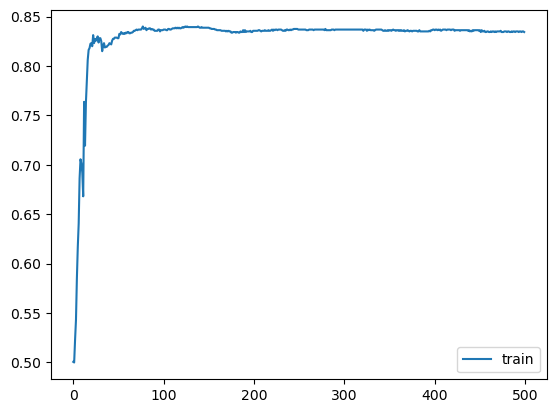

In [33]:
plt.plot(history_deeprelu.history[:, 'valid_acc'], label='train')
plt.legend()
plt.show()

In [34]:
# evaluate the model
predictions_deeprelu = deepnet_relu.predict(testX)
test_acc_deeprelu = np.sum(predictions_deeprelu == testy.astype(int)) / len(testy)
print(f'Average test accuracy: {test_acc_deeprelu}')

Average test accuracy: 0.832


In [35]:
del history_deeprelu

In [36]:
del deepnet_relu